# Medical Insurance Cost Analysis

Author: Sylas Chacko

Date: 8/30/2024

### Data Exploration

In [1]:
# Imports
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv(r'insurance_data.csv')

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Exploratory Data Analysis

In [4]:
# Check for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Display the first few rows of the encoded data
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


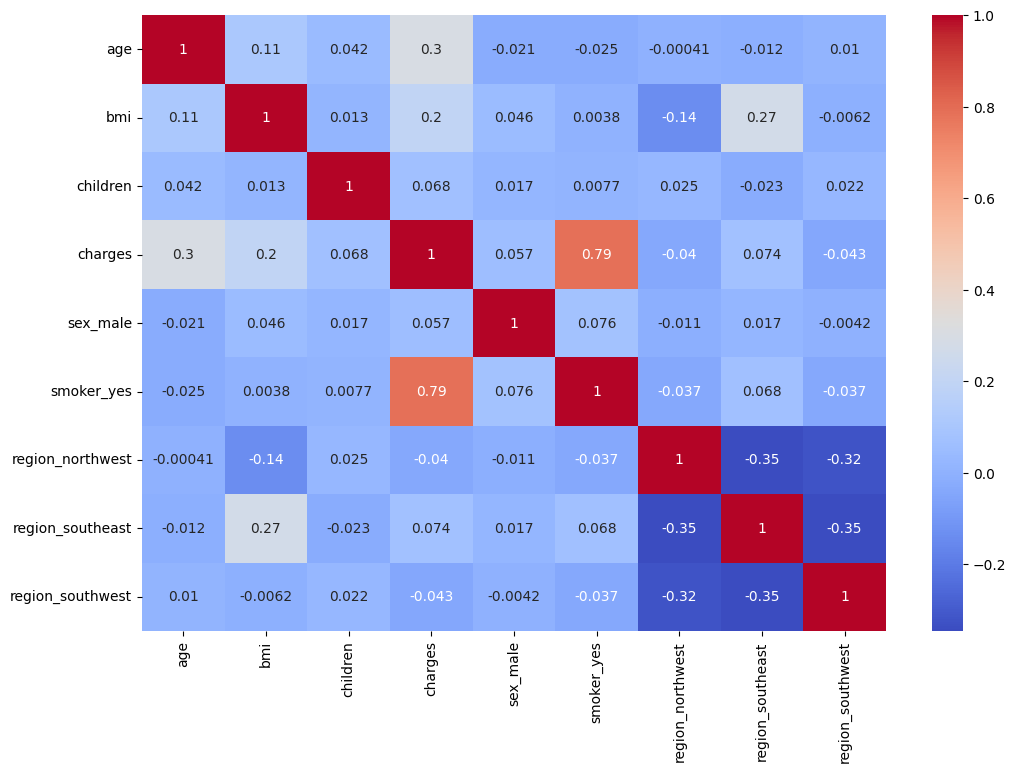

In [7]:
# Correlation heatmap after encoding categorical variables
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.show()

In [9]:
# Create a pipeline with scaling and regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # This step scales the numerical features
    ('regressor', LinearRegression())
])

### Model

In [10]:
# Define the features and target variable
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [12]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 33596915.85136148
R-squared: 0.7835929767120722


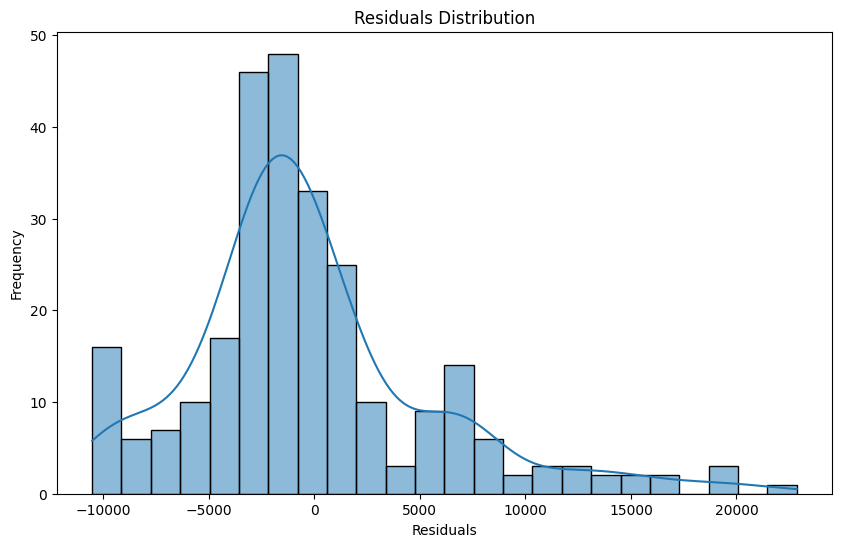

In [13]:
# Residual analysis to check model performance
residuals = y_test - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [14]:
# Extract and display the model coefficients
coefficients = pipeline.named_steps['regressor'].coef_
features = X.columns

# Combine feature names with their corresponding coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort by absolute value of the coefficients for better interpretation
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the coefficients
coef_df.drop(columns='Abs_Coefficient', inplace=True)
coef_df

,Feature,Coefficient
4,smoker_yes,9558.481409
0,age,3614.975415
1,bmi,2036.228123
2,children,516.890247
7,region_southwest,-349.110678
6,region_southeast,-290.157047
5,region_northwest,-158.140981
3,sex_male,-9.293101


In [15]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the Ridge model with a pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define hyperparameters for tuning
ridge_params = {'ridge__alpha': [0.1, 1.0, 10, 100]}

# Perform Grid Search with Cross-Validation
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)

# Get the best parameters and score
print(f"Best Ridge Params: {ridge_grid.best_params_}")
print(f"Best Ridge R-squared: {ridge_grid.best_score_}")

# Evaluate on test set
ridge_best = ridge_grid.best_estimator_
ridge_pred = ridge_best.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"Ridge Test MSE: {ridge_mse}")
print(f"Ridge Test R-squared: {ridge_r2}")


Best Ridge Params: {'ridge__alpha': 10}
Best Ridge R-squared: 0.7331764678144241
Ridge Test MSE: 33685862.85657276
Ridge Test R-squared: 0.7830200444609897


In [16]:
from sklearn.linear_model import Lasso

# Define the Lasso model with a pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Define hyperparameters for tuning
lasso_params = {'lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10]}

# Perform Grid Search with Cross-Validation
lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='r2')
lasso_grid.fit(X_train, y_train)

# Get the best parameters and score
print(f"Best Lasso Params: {lasso_grid.best_params_}")
print(f"Best Lasso R-squared: {lasso_grid.best_score_}")

# Evaluate on test set
lasso_best = lasso_grid.best_estimator_
lasso_pred = lasso_best.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"Lasso Test MSE: {lasso_mse}")
print(f"Lasso Test R-squared: {lasso_r2}")


Best Lasso Params: {'lasso__alpha': 10}
Best Lasso R-squared: 0.733188657928274
Lasso Test MSE: 33639307.75515306
Lasso Test R-squared: 0.7833199187399764
